# Graphstorm Standalone Mode Demonstration

In this notebook, we'll demonstrate how to use the standalone mode of Graphstorm. The standalone mode is primarily designed for model developers to prototype their data and model training/evaluation/inference pipelines using a single machine. 

---

## Setup 

This notebook requires installing graphstorm using pip. Please find [more details on installation of graphstorm](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages).

In [1]:
# !pip install git+https://github.com/awslabs/graphstorm

In [2]:
import os
import matplotlib.pyplot as plt
# import graphstorm related stuffs
import graphstorm as gs
from graphstorm.trainer import GSgnnNodePredictionTrainer
from graphstorm.dataloading import GSgnnNodeTrainData, GSgnnNodeDataLoader, GSgnnNodeInferData
from graphstorm.model import GSgnnNodeModel, GSNodeEncoderInputLayer, EntityClassifier, ClassifyLossFunc, RelationalGCNEncoder
from graphstorm.inference import GSgnnNodePredictionInferrer
from graphstorm.eval import GSgnnClassificationEvaluator

In [3]:
# initialize the graphstorm standalone environment
gs.initialize(ip_config=None, backend='gloo', local_rank=0)
device = gs.utils.get_device()

## Develop a GNN model for node-classification 

Next, we use a GNN model to go over the model development cycle of a node classification problem on the MovieLens dataset. 


### 0. Load the constructed graph data

In this demo we use the MovieLens graph constructed by [graphstorm's processing pipeline](https://graphstorm.readthedocs.io/en/latest/gs-processing/usage/example.html).

In [4]:
# constructed graphstorm data config:
constructed_graph_config = '/mnt/efs/gsf-data/movielen_100k_train_val_1p_4t/movie-lens-100k.json'

In [5]:
# config about the dataset and task:
graph_name = 'movie-lens-100k'
target_ntype = 'movie'
node_feat_name = None
feat_sizes = {'movie': 0, 'user': 0}
label_field = 'label'
num_classes = 19
multilabel = False

# learning params:
batch_size = 128
lr = 0.001
sparse_optimizer_lr = 0.01
weight_decay = 0.

# model architecture:
hidden_size = 128
fanout = [4]
dropout = 0.0
num_bases = -1
num_layers = 1
use_self_loop = True

In [6]:
# load the constructed graph data
train_data = GSgnnNodeTrainData(
    graph_name=graph_name,
    part_config=constructed_graph_config,
    train_ntypes=target_ntype,
    eval_ntypes=target_ntype,
    node_feat_field=node_feat_name,
    label_field=label_field)

In [7]:
# train_data.g stores a DistGraph object
print('Number of nodes:')
for ntype in train_data.g.ntypes:
    print(f'- {ntype}: {train_data.g.num_nodes(ntype)}')
print('Number of edges:')
for etype in train_data.g.etypes:
    print(f'- {etype}: {train_data.g.num_edges(etype)}')

Number of nodes:
- movie: 1682
- user: 943
Number of edges:
- rating-rev: 100000
- rating: 100000


In [8]:
# set up data loaders
dataloader = GSgnnNodeDataLoader(
    train_data, train_data.train_idxs, fanout=fanout,
    batch_size=batch_size,
    train_task=True)

val_dataloader = GSgnnNodeDataLoader(
    train_data, train_data.val_idxs, fanout=fanout,
    batch_size=batch_size,
    train_task=False)

test_dataloader = GSgnnNodeDataLoader(
    train_data, train_data.test_idxs, fanout=fanout,
    batch_size=batch_size,
    train_task=False)

### 2. Create a GNN model

A GSF model should contain the following components: 
- Input encoder for nodes (and optionally edges): process and project input features and embeddings into a certain dimension
- GNN encoder: performs message-passing on projected node/edge inputs
- Decoder: specific for tasks on the graph

We can see the following codes set up a `GSgnnNodeModel` model composed of `GSNodeEncoderInputLayer`, `RelationalGCNEncoder`, `EntityClassifier` step-by-step. One can also replace individual components/layers with a custom model for development purpose.

In [9]:
# create a gsf model
model = GSgnnNodeModel(alpha_l2norm=0.)

# set input layer encoder
encoder = GSNodeEncoderInputLayer(
    train_data.g,
    feat_sizes,
    hidden_size,
    dropout=dropout,
    activation=None)
model.set_node_input_encoder(encoder)

# set GNN encoder
gnn_encoder = RelationalGCNEncoder(
    train_data.g,
    hidden_size, hidden_size,
    num_bases=num_bases,
    num_hidden_layers=num_layers - 1,
    dropout=dropout,
    use_self_loop=use_self_loop)
model.set_gnn_encoder(gnn_encoder)

# set decoder specific to node-classification task
model.set_decoder(EntityClassifier(
    model.node_input_encoder.out_dims,
    num_classes,
    multilabel))
# classification loss function
model.set_loss_func(ClassifyLossFunc(multilabel))

model.init_optimizer(
    lr=lr,
    sparse_optimizer_lr=sparse_optimizer_lr,
    weight_decay=weight_decay
    )

model

GSgnnNodeModel(
  (_node_input_encoder): GSNodeEncoderInputLayer(
    (dropout): Dropout(p=0.0, inplace=False)
    (proj_matrix): ParameterDict(
        (movie): Parameter containing: [torch.FloatTensor of size 128x128]
        (user): Parameter containing: [torch.FloatTensor of size 128x128]
    )
    (input_projs): ParameterDict()
    (ngnn_mlp): ModuleDict(
      (movie): NGNNMLP(
        (dropout): Dropout(p=0.0, inplace=False)
        (ngnn_gnn): ParameterList()
      )
      (user): NGNNMLP(
        (dropout): Dropout(p=0.0, inplace=False)
        (ngnn_gnn): ParameterList()
      )
    )
  )
  (_gnn_encoder): RelationalGCNEncoder(
    (_layers): ModuleList(
      (0): RelGraphConvLayer(
        (conv): HeteroGraphConv(
          (mods): ModuleDict(
            (('movie', 'rating-rev', 'user')): GraphConv(in=128, out=128, normalization=right, activation=None)
            (('user', 'rating', 'movie')): GraphConv(in=128, out=128, normalization=right, activation=None)
          )
  

### 3. Create a graphstorm trainer and train the model
The trainers is task-specific in graphstorm. It handles:
1. model training/evaluation loops
2. saving and restoring model checkpoints
3. early-stopping

In [10]:
# create a trainer for the model
trainer = GSgnnNodePredictionTrainer(
    model,
    topk_model_to_save=1)

# set up device for the trainer
trainer.setup_device(device=device)

# set up evaluator for the trainer:
evaluator = GSgnnClassificationEvaluator(
    eval_frequency=10000,
    multilabel=multilabel)

trainer.setup_evaluator(evaluator)

In [11]:
# Train the model with the trainer
trainer.fit(
    train_loader=dataloader,
    val_loader=val_dataloader,
    test_loader=test_dataloader,
    num_epochs=10,
    save_model_path='nc_model/',
)

Next, we examine the model performance over the training process

In [12]:
# Extract accuracies from the trainer's evaluator:
val_accs, test_accs = [], []
for val_acc, test_acc in trainer.evaluator.history:
    val_accs.append(val_acc['accuracy'])
    test_accs.append(test_acc['accuracy'])

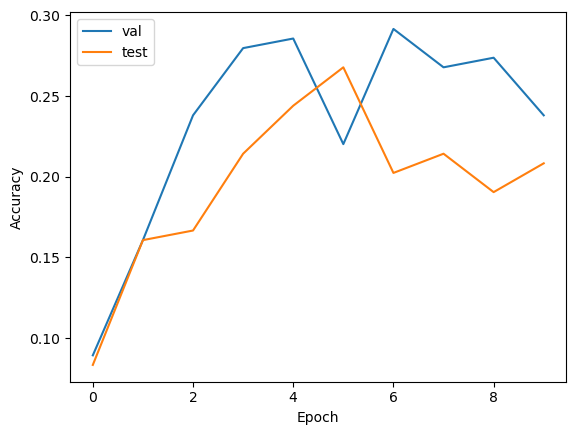

In [13]:
# plot the learning curves
fig, ax = plt.subplots()
ax.plot(val_accs, label='val')
ax.plot(test_accs, label='test')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend(loc='best');

In [14]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model checkpoint:', best_model_path)

Best model checkpoint: nc_model/epoch-6


In [15]:
# check the saved artifacts
!ls -ls {best_model_path}

total 1012
336 -rw-rw-r-- 1 ubuntu ubuntu 340551 Oct 11 15:07 model.bin
  4 drwxrw-rwx 2 ubuntu ubuntu   4096 Oct 11 15:07 movie
668 -rw-rw-r-- 1 ubuntu ubuntu 681259 Oct 11 15:07 optimizers.bin
  4 drwxrw-rwx 2 ubuntu ubuntu   4096 Oct 11 15:07 user


### 3. Inference with the trained model

In [16]:
# we can restore the model from the checkpoint:
model.restore_model(best_model_path)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [17]:
# Create a dataset for inference, we use the same MovieLens graph
infer_data = GSgnnNodeInferData(
    graph_name,
    constructed_graph_config,
    eval_ntypes=target_ntype,
    node_feat_field=node_feat_name,
    label_field=label_field)

# Set up dataloader for the inference dataset
infer_dataloader = GSgnnNodeDataLoader(
    infer_data, infer_data.test_idxs, fanout=fanout,
    batch_size=100,
    train_task=False)


# Create an Inferrer object
infer = GSgnnNodePredictionInferrer(model)
infer.setup_device(device=device)
infer.setup_evaluator(evaluator)


In [18]:
# Run inference on the inference dataset
infer.infer(infer_dataloader,
            save_embed_path=os.path.join(best_model_path, 'infer/embeddings'),
            save_prediction_path=os.path.join(best_model_path, 'infer/predictions'),
            use_mini_batch_infer=True)

In [19]:
# The GNN embeddings on the inference graph are saved to:
!ls -lh {best_model_path}/infer/embeddings

total 848K
-rw-rw-r-- 1 ubuntu ubuntu   40 Oct 11 15:07 emb_info.json
-rw-rw-r-- 1 ubuntu ubuntu 842K Oct 11 15:07 movie_emb.part00000.bin


In [20]:
!ls -lh {best_model_path}/infer/predictions

total 16K
-rw-rw-r-- 1 ubuntu ubuntu 14K Oct 11 15:07 predict-00000.pt
